### Шаг 1. Исследовательский анализ данных Fashion MNIST

- датасет [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 42
DATASET_PATH = "dataset"

In [3]:
# Загрузка датасета с базовой трансформацией
train_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH, train=False, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.64MB/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.22MB/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



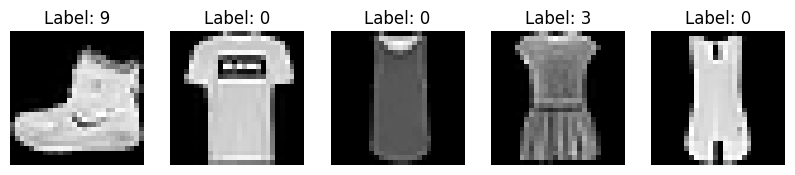

In [4]:
# Визуализация нескольких изображений
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.savefig('labels_examples.png')
plt.show()

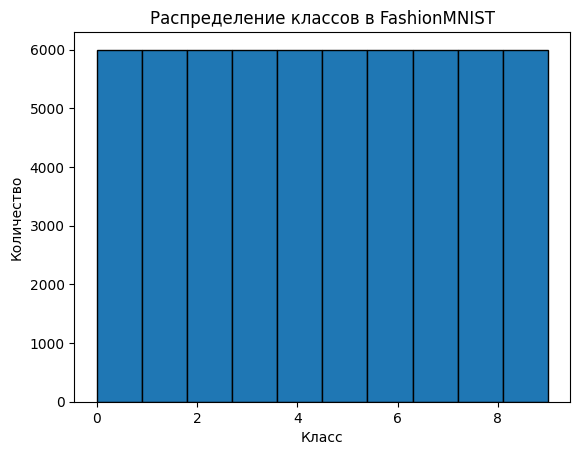

In [5]:
# Распределение классов
train_labels = [label for _, label in train_dataset]
plt.hist(train_labels, bins=10, edgecolor='black')
plt.title('Распределение классов в FashionMNIST')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.savefig('Распределение классов в FashionMNIST.png')
plt.show()

In [6]:
# Статистика для нормализации
imgs = torch.stack([img for img, _ in train_dataset], dim=0)
mean = imgs.mean().item()
std = imgs.std().item()
print(f'Среднее: {mean:.4f}, Стандартное отклонение: {std:.4f}')

# Среднее значение пикселей: ~0.2860, стандартное отклонение: ~0.3530.

Среднее: 0.2860, Стандартное отклонение: 0.3530


### Шаг 2. Определение классов моделей

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
"""
Генератор: Принимает шум z и метку класса labels, объединяет их и генерирует изображение 28x28.
Дискриминатор: Принимает изображение и метку класса, объединяет их и оценивает подлинность.
"""

import torch.nn as nn

# Условный генератор
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super(ConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)  # Преобразование метки в плотное представление
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 128, 7, stride=1, padding=0),  # (latent_dim + num_classes, 1, 1) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # (128, 7, 7) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),  # (64, 14, 14) -> (1, 28, 28)
            nn.Tanh()  # Вывод в диапазоне [-1, 1]
        )

    def forward(self, z, labels):
        labels = self.label_emb(labels)  # Преобразование меток в эмбеддинги
        labels = labels.view(-1, self.num_classes, 1, 1)
        z = z.view(-1, self.latent_dim, 1, 1)
        input = torch.cat([z, labels], dim=1)  # Объединение шума и меток
        return self.model(input)

# Условный дискриминатор
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(1 + num_classes, 64, 4, stride=2, padding=1),  # (1 + num_classes, 28, 28) -> (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (64, 14, 14) -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, stride=1, padding=0),  # (128, 7, 7) -> (1, 1, 1)
            nn.Sigmoid()  # Вероятность реальности
        )

    def forward(self, img, labels):
        labels = self.label_emb(labels)
        labels = labels.view(-1, num_classes, 1, 1)
        labels = labels.expand(-1, -1, img.size(2), img.size(3))  # Расширение меток до размера изображения
        input = torch.cat([img, labels], dim=1)  # Объединение изображения и меток
        return self.model(input)

# Классификатор (для оценки сгенерированных изображений)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (64, 14, 14) -> (64, 7, 7)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 10),  # (64*7*7) -> (10)
            nn.Softmax(dim=1)  # Вероятности для 10 классов
        )

    def forward(self, x):
        return self.model(x)

- [Выбор слоя активации в нейронных сетях: как правильно выбрать для вашей задачи](https://habr.com/ru/articles/727506/)
- [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA)
- [CNN Explainer](https://poloclub.github.io/cnn-explainer/)
- Оригинальная статья, вводящая понятие CNN — [Neocognitron: A Self-organizing Neural Network Model for a Mechanism of Pattern Recognition Unaffected by Shift in Position](https://link.springer.com/article/10.1007/BF00344251)
- Возможно, вот это оригинальная статья — [Backpropagation Applied to Handwritten Zip Code Recognition](https://ieeexplore.ieee.org/document/6795724)

### Шаг 3. Раздельное обучение моделей

In [ ]:
import json

"""
Сохраняем параметры для анализа.
"""

def save_params(model, epoch, loss, filename):
    params = {
        "epoch": epoch,
        "loss": loss,
        "model_state": {k: v.tolist() for k, v in model.state_dict().items()}
    }
    with open(filename, "w") as f:
        json.dump(params, f)

- [Image Augmentation](https://d2l.ai/chapter_computer-vision/image-augmentation.html)
- [Transforming and augmenting images](https://pytorch.org/vision/main/transforms.html)

In [ ]:
"""
Обучение классификатора
Классификатор обучается отдельно для последующей оценки сгенерированных изображений.
"""

from torch.utils.data import DataLoader
import torch.optim as optim

CLASSIFIER_LEARNING_RATE = 0.0001
CLASSIFIER_BATCH_SIZE = 32
CLASSIFIER_EPOCHS = 20

# Подготовка данных с аугментацией
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,))
])
train_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH,
                                                  train=True,
                                                  download=True,
                                                  transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=CLASSIFIER_BATCH_SIZE,
                          shuffle=True)

# Инициализация классификатора
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=CLASSIFIER_LEARNING_RATE)

classifier_losses = []
# Цикл обучения
for epoch in range(CLASSIFIER_EPOCHS):
    classifier.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = classifier(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')

    avg_loss = running_loss / len(train_loader)
    classifier_losses.append(avg_loss)

    save_params(classifier, epoch+1, running_loss, f"classifier_params_epoch_{epoch+1}.json")

# Сохранение модели
torch.save(classifier.state_dict(), 'classifier.pth')

Epoch 1, Loss: 1.6950
Epoch 2, Loss: 1.6225
Epoch 3, Loss: 1.6059
Epoch 4, Loss: 1.5968
Epoch 5, Loss: 1.5898
Epoch 6, Loss: 1.5844
Epoch 7, Loss: 1.5799
Epoch 8, Loss: 1.5763
Epoch 9, Loss: 1.5728
Epoch 10, Loss: 1.5712
Epoch 11, Loss: 1.5680
Epoch 12, Loss: 1.5678
Epoch 13, Loss: 1.5652
Epoch 14, Loss: 1.5634
Epoch 15, Loss: 1.5624
Epoch 16, Loss: 1.5612
Epoch 17, Loss: 1.5602
Epoch 18, Loss: 1.5588
Epoch 19, Loss: 1.5576
Epoch 20, Loss: 1.5572


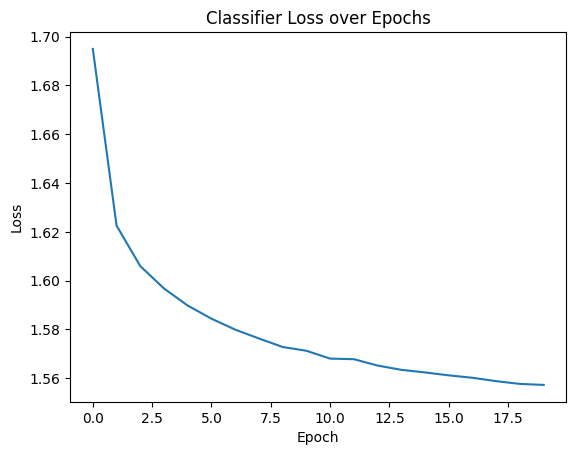

In [ ]:
plt.plot(classifier_losses)
plt.title('Classifier Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('classifier_loss.png')
plt.show()

- [Complete Guide to the Adam Optimization Algorithm](https://builtin.com/machine-learning/adam-optimization)
- [Comprehensive overview of solvers/optimizers in Deep Learning](https://wiki.cloudfactory.com/docs/mp-wiki/solvers-optimizers/comprehensive-overview-of-solvers-optimizers-in-deep-learning#:~:text=In%20deep%20learning%2C%20the%20optimizer,best%20on%20a%20given%20task.)

In [ ]:
"""
Обучение CGAN
Генератор и дискриминатор обучаются совместно в рамках состязательного процесса.
"""

# Инициализация моделей
latent_dim = 100
num_classes = 10
generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes).to(device)
discriminator = ConditionalDiscriminator(num_classes=num_classes).to(device)

# Гиперпараметры обучения
DISCRIMINATOR_LEARNING_RATE = 0.0001
GENERATOR_LEARNING_RATE = 0.0001
CGAN_EPOCHS = 20
CGAN_BATCH_SIZE = 32

# Оптимизаторы
d_optimizer = optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(0.5, 0.999)) # betas — затухание оценки первого момента
g_optimizer = optim.Adam(generator.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(0.5, 0.999)) # betas — затухание оценки второго момента

# Лосс
adversarial_loss = nn.BCELoss().to(device)

# Подготовка данных
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,))
])
train_dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=CGAN_BATCH_SIZE, shuffle=True)

d_losses, g_losses = [], []
# Обучение CGAN
for epoch in range(CGAN_EPOCHS):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        # Метки для реальных и фейковых данных
        real_label = torch.ones(batch_size, 1, 1, 1).to(device)
        fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)

        # Обучение дискриминатора
        d_optimizer.zero_grad()
        real_output = discriminator(imgs, labels)
        d_real_loss = adversarial_loss(real_output, real_label)

        z = torch.randn(batch_size, latent_dim, 1, 1)
        z = z.to(device)

        fake_labels = torch.randint(0, num_classes, (batch_size,))
        fake_labels = fake_labels.to(device)
        fake_imgs = generator(z, fake_labels)
        fake_output = discriminator(fake_imgs.detach(), fake_labels)
        d_fake_loss = adversarial_loss(fake_output, fake_label)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Обучение генератора
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_imgs, fake_labels)
        g_loss = adversarial_loss(fake_output, real_label)

        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{CGAN_EPOCHS}] Batch [{i}/{len(train_loader)}] '
                  f'D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}')

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        #save_params(generator, epoch+1, g_loss.tolist(), f"generator_params_epoch_{epoch+1}.json")
        #save_params(discriminator, epoch+1, d_loss.tolist(), f"discriminator_params_epoch_{epoch+1}.json")

# Сохранение моделей
torch.save(generator.state_dict(), f'conditional_generator.pth')
torch.save(discriminator.state_dict(), f'conditional_discriminator.pth')

Epoch [1/20] Batch [0/1875] D Loss: 1.4242 G Loss: 0.8343
Epoch [1/20] Batch [100/1875] D Loss: 0.8185 G Loss: 1.4484
Epoch [1/20] Batch [200/1875] D Loss: 0.9453 G Loss: 1.6214
Epoch [1/20] Batch [300/1875] D Loss: 0.1232 G Loss: 2.9486
Epoch [1/20] Batch [400/1875] D Loss: 0.0623 G Loss: 3.6419
Epoch [1/20] Batch [500/1875] D Loss: 0.0452 G Loss: 4.1734
Epoch [1/20] Batch [600/1875] D Loss: 0.0124 G Loss: 4.9740
Epoch [1/20] Batch [700/1875] D Loss: 0.0213 G Loss: 4.9871
Epoch [1/20] Batch [800/1875] D Loss: 0.0098 G Loss: 5.0474
Epoch [1/20] Batch [900/1875] D Loss: 0.0072 G Loss: 6.0125
Epoch [1/20] Batch [1000/1875] D Loss: 0.0061 G Loss: 6.0956
Epoch [1/20] Batch [1100/1875] D Loss: 0.0088 G Loss: 5.4449
Epoch [1/20] Batch [1200/1875] D Loss: 0.0215 G Loss: 5.8239
Epoch [1/20] Batch [1300/1875] D Loss: 0.0036 G Loss: 6.1159
Epoch [1/20] Batch [1400/1875] D Loss: 0.0033 G Loss: 5.9248
Epoch [1/20] Batch [1500/1875] D Loss: 0.0036 G Loss: 6.7928
Epoch [1/20] Batch [1600/1875] D Los

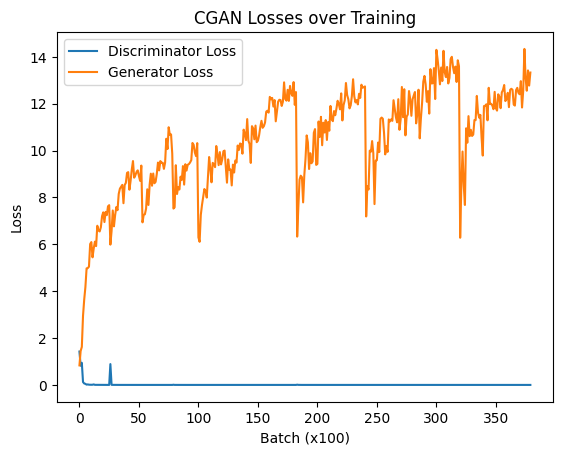

In [ ]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('CGAN Losses over Training')
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cgan_losses.png')
plt.show()

### Шаг 5. Оценка метрик и визуализация

In [ ]:
"""
Оценка классификатора
"""

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
classifier.eval()
preds, true_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = classifier(imgs.to(device))
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61      1000
           1       0.97      0.91      0.94      1000
           2       0.38      0.86      0.53      1000
           3       1.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.55      0.05      0.09      1000
           7       0.00      0.00      0.00      1000
           8       0.32      0.99      0.48      1000
           9       0.36      0.95      0.52      1000

    accuracy                           0.44     10000
   macro avg       0.42      0.44      0.32     10000
weighted avg       0.42      0.44      0.32     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


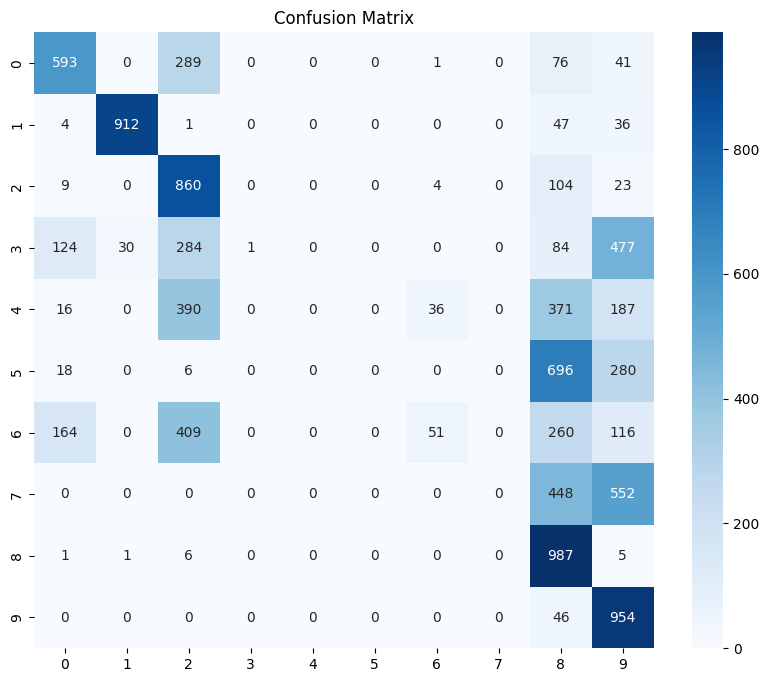

In [ ]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

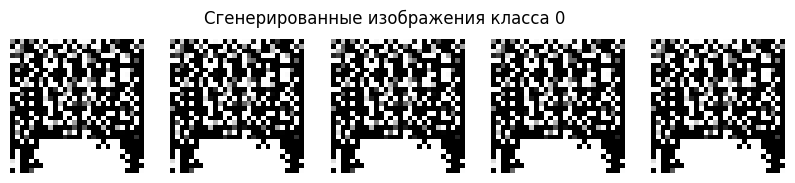

In [ ]:
"""
Визуализация сгенерированных изображений
"""

# Генерация изображений для класса 0 (футболка)
desired_class = 0
z = torch.randn(5, latent_dim, 1, 1).to(device)
labels = torch.full((5,), desired_class, dtype=torch.long).to(device)

generator.eval()
with torch.no_grad():
    fake_imgs = generator(z, labels).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_imgs[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'Сгенерированные изображения класса {desired_class}')
plt.savefig('generated_images_class_0.png')
plt.show()

### Шаг 6. Загрузка моделей

In [ ]:
# Загрузка
classifier = Classifier()
classifier.load_state_dict(torch.load('classifier.pth'))

generator = ConditionalGenerator(latent_dim=latent_dim, num_classes=num_classes)
generator.load_state_dict(torch.load('conditional_generator.pth'))

discriminator = ConditionalDiscriminator(num_classes=num_classes)
discriminator.load_state_dict(torch.load('conditional_discriminator.pth'))

<ipython-input-29-4b323f4a4a89>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('classifier.pth'))
<ipython-input-29-4b323f4a4a89>:6: 

<All keys matched successfully>

### Шаг 7. Инференс моделей

Дискриминатор: 0.9875 (вероятность реальности)
Классификатор: Класс 8


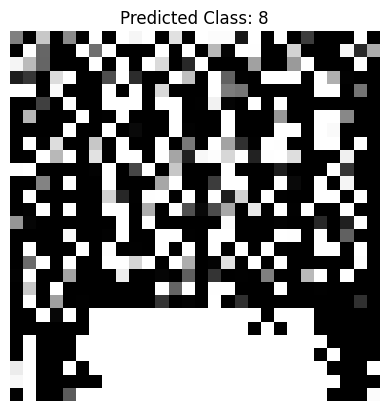

In [ ]:
generator.eval()
discriminator.eval()
classifier.eval()

desired_class = 0
z = torch.randn(1, latent_dim, 1, 1)
label = torch.tensor([desired_class])

with torch.no_grad():
    generated_img = generator(z, label)
    disc_pred = discriminator(generated_img, label)
    print(f'Дискриминатор: {disc_pred.item():.4f} (вероятность реальности)')
    class_pred = classifier(generated_img)
    predicted_class = class_pred.argmax(dim=1).item()
    print(f'Классификатор: Класс {predicted_class}')
    plt.imshow(generated_img.squeeze().cpu(), cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.savefig('inference_example_class_0.png')
    plt.show()

### Домашнее задание

- Дедлайн: 13 марта, 18:00 (GMT+3)
- Формат подачи: Отчет, файл в формате .pdf (включена ссылка на исходный код в GitHub или Google Collab)

**Задание:**


В этом домашнем задании вам будет необходимо исследование различных факторов на сходмость моделей классификации, генерации и дискриминации, а также обучить модель Conditional GAN на собственном наборе данных.

1. Обучите модель Conditional GAN на любом наборе данных на свой вкус. Можете начать поиски среди любых наборов данных для классификации в компьютерном зрении [(к примеру)](https://www.kaggle.com/datasets?tags=13302-Classification) (30%). Сгенерируйте хотя бы по одному изображению на каждый класс (10%).

2. Исследуйте влияние случайной инициализации в слоях Conv2d и ConvTranspose2d на обучение модели Conditional GAN. Примените случайную инициализацию хотя бы из двух вероятностных распределений (30%).

3. Подготовьте ответы на следующие вопросы:
- Чем отличается Conditional GAN от обычного GAN? Объясните, как вводится условная информация в генератор и дискриминатор. (10%)
- Почему обучение GAN может быть нестабильным, и какие техники помогают стабилизировать процесс? (10%)
- Какую роль играет латентное пространство в генерации изображений? Как условная информация влияет на него в CGAN? (10%)

**Примечание:**

- Вы можете свободно модифицировать количественные и качественные характериситики моделей,
- Вы можете свободно выбирать гиперпараметры в моделях,
- Вы можете свободно добавлять и исключать аугментацию данных,
- Качество генерации не будет оцениваться напрямую. Сделайте так, чтобы ваша работа наглядно демонстрировала ваш ход мысли: на какие источники опирались, какие улучшения вносили, какие гипотезы вносили и т.д.;

**Подсказки:**

- Изучите концепцию [Early Stopping](https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html), она может оказаться полезной,
- Зачастую, глубокое обучение — экспериментальная и эмпирическая область. Не стесняйтесь проверять [советы и трюки](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9), опробованные до вас,
- Используйте простой пример на NumPy, чтобы быстро проверить гипотезу;

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm


In [22]:
# Гиперпараметры
RANDOM_SEED = 42
DATASET_PATH = "./data"
LATENT_DIM = 100
NUM_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.0002
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# 1. Загрузка и подготовка данных CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root=DATASET_PATH, train=True, download=True, transform=transform)

Files already downloaded and verified


In [24]:
# 2. Определение архитектуры CGAN
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        labels = self.label_emb(labels).view(-1, self.num_classes, 1, 1)
        z = z.view(-1, self.latent_dim, 1, 1)
        return self.model(torch.cat([z, labels], 1))

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        labels = self.label_emb(labels).view(-1, self.num_classes, 1, 1)
        labels = labels.expand(-1, -1, img.size(2), img.size(3))
        return self.model(torch.cat([img, labels], 1))

In [25]:
def init_weights_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_uniform(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.uniform_(m.weight, -0.1, 0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [26]:
# 4. Функция обучения
def train_cgan(init_type='normal'):
    # Инициализация моделей
    generator = ConditionalGenerator(LATENT_DIM, NUM_CLASSES).to(DEVICE)
    discriminator = ConditionalDiscriminator(NUM_CLASSES).to(DEVICE)

    if init_type == 'normal':
        generator.apply(init_weights_normal)
        discriminator.apply(init_weights_normal)
    elif init_type == 'uniform':
        generator.apply(init_weights_uniform)
        discriminator.apply(init_weights_uniform)

    # Оптимизаторы
    optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

    # Лосс
    adversarial_loss = nn.BCELoss()

    # Лоссы для сохранения
    losses_G = []
    losses_D = []

    # Цикл обучения
    for epoch in range(EPOCHS):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [{init_type}]')
        for i, (imgs, labels) in enumerate(progress_bar):
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            batch_size = imgs.size(0)

            # Метки для реальных и фейковых данных
            real_label = torch.ones(batch_size, 1, 1, 1, device=DEVICE)
            fake_label = torch.zeros(batch_size, 1, 1, 1, device=DEVICE)

            # Обучение дискриминатора
            optimizer_D.zero_grad()

            # Реальные данные
            real_output = discriminator(imgs, labels)
            d_real_loss = adversarial_loss(real_output, real_label)

            # Фейковые данные
            z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
            fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=DEVICE)
            fake_imgs = generator(z, fake_labels)
            fake_output = discriminator(fake_imgs.detach(), fake_labels)
            d_fake_loss = adversarial_loss(fake_output, fake_label)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Обучение генератора
            optimizer_G.zero_grad()
            fake_output = discriminator(fake_imgs, fake_labels)
            g_loss = adversarial_loss(fake_output, real_label)
            g_loss.backward()
            optimizer_G.step()

            # Сохранение потерь
            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())

            progress_bar.set_postfix({
                'G Loss': f'{g_loss.item():.4f}',
                'D Loss': f'{d_loss.item():.4f}'
            })

    return generator, losses_G, losses_D


In [27]:
# Функция для генерации изображения
def generate_and_plot(generator, init_type):
    generator.eval()
    fig = plt.figure(figsize=(20, 6))  # Увеличенный размер фигуры
    fig.suptitle(f'Generated Images ({init_type} Initialization)', fontsize=16, y=1.05)

    for class_idx in range(NUM_CLASSES):
        z = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
        labels = torch.full((1,), class_idx, dtype=torch.long, device=DEVICE)

        with torch.no_grad():
            generated = generator(z, labels).cpu()

        ax = fig.add_subplot(2, 5, class_idx + 1)
        ax.imshow(generated[0].permute(1, 2, 0) * 0.5 + 0.5, vmin=0, vmax=1)  # Нормализация и улучшение контраста
        ax.set_title(f'Class {class_idx}', fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_{init_type}.png', bbox_inches='tight', dpi=300)  # Сохранение с высоким качеством
    plt.show()

In [28]:
# Обучение
normal_generator, normal_g_loss, normal_d_loss = train_cgan(init_type='normal')
uniform_generator, uniform_g_loss, uniform_d_loss = train_cgan(init_type='uniform')

Epoch 15/15 [uniform]: 100%|██████████| 782/782 [00:29<00:00, 26.49it/s, G Loss=0.9690, D Loss=1.4848]


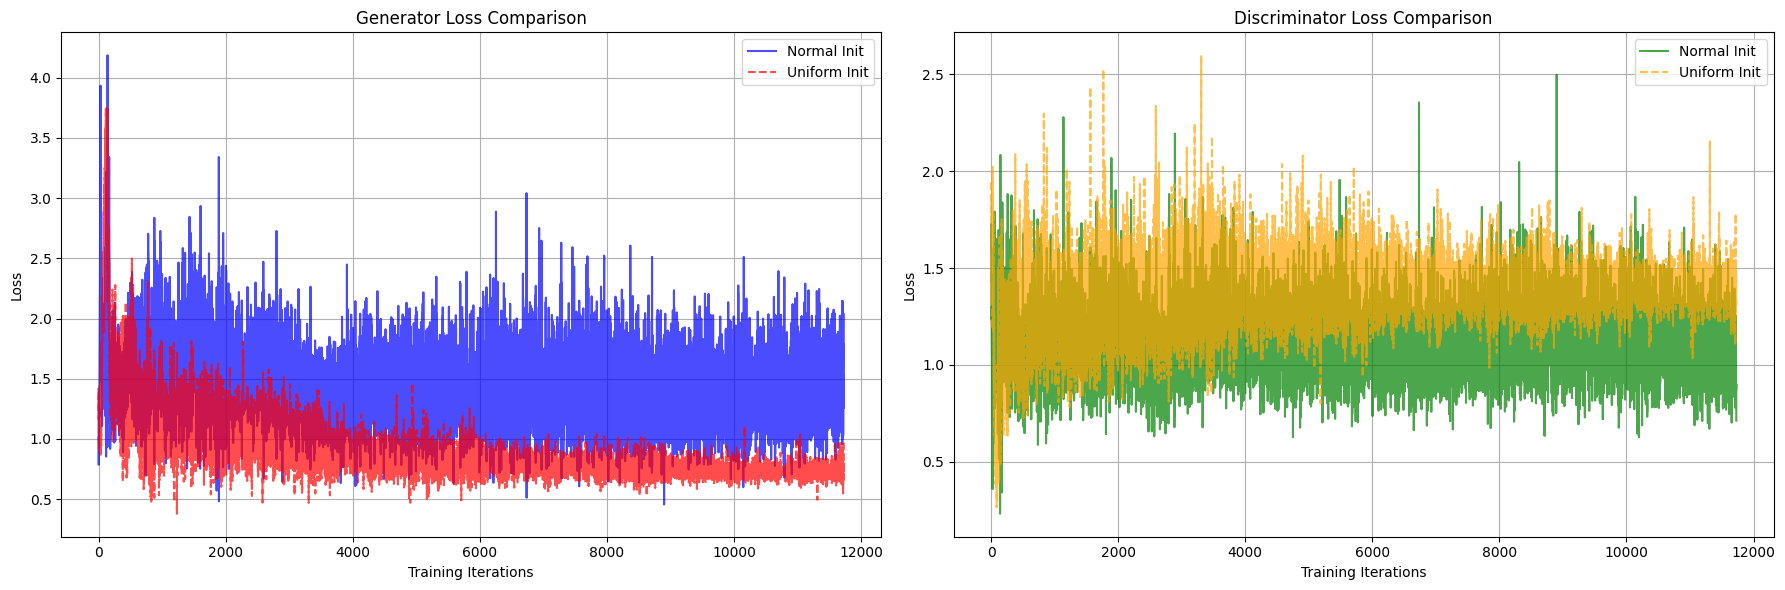

In [29]:
# 6. Сравнение лоссов
plt.figure(figsize=(18, 6))

# График для генератора
plt.subplot(1, 2, 1)
plt.plot(normal_g_loss, label='Normal Init', color='blue', alpha=0.7)
plt.plot(uniform_g_loss, '--', label='Uniform Init', color='red', alpha=0.7)
plt.title('Generator Loss Comparison')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для дискриминатора
plt.subplot(1, 2, 2)
plt.plot(normal_d_loss, label='Normal Init', color='green', alpha=0.7)
plt.plot(uniform_d_loss, '--', label='Uniform Init', color='orange', alpha=0.7)
plt.title('Discriminator Loss Comparison')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_comparison_side_by_side.png')
plt.show()

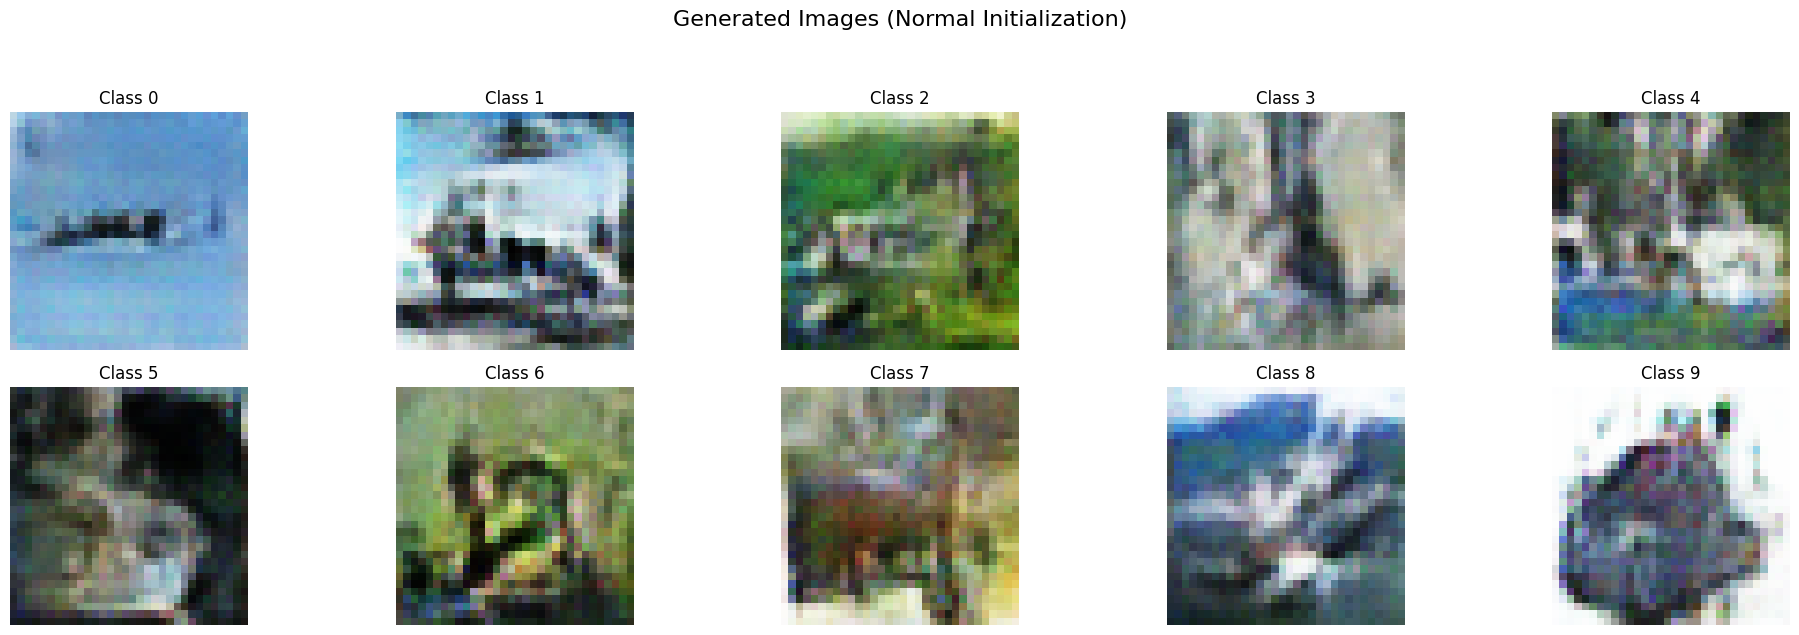

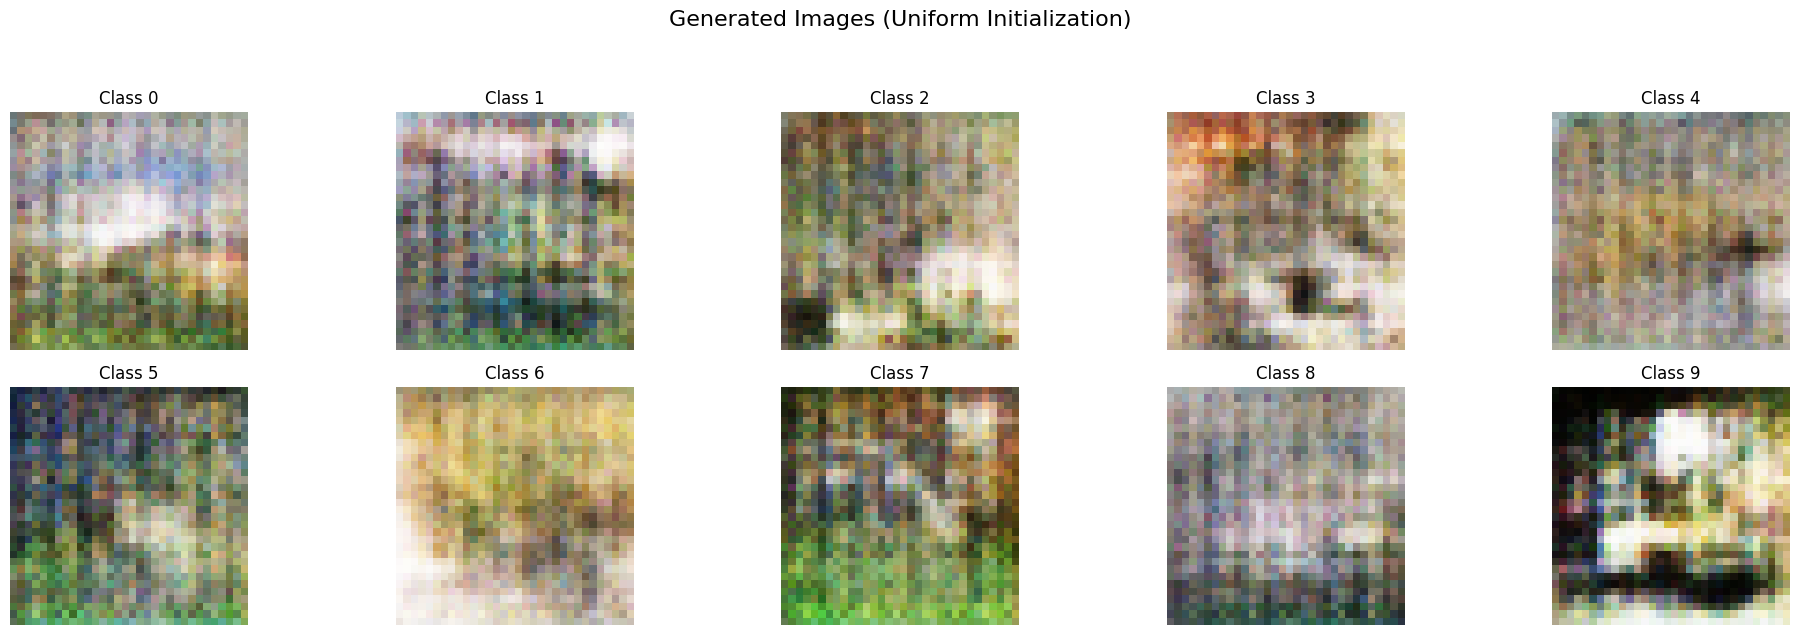

In [30]:
# Генерация изображений для обеих инициализаций
generate_and_plot(normal_generator, 'Normal')
generate_and_plot(uniform_generator, 'Uniform')